In [1]:
import os
import random
import pyreadr

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, TimeDistributed, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.callbacks import EarlyStopping
import tensorflow as tf

import dues_utilities as utils

Using TensorFlow backend.


In [2]:
tf.random.set_seed(77)
os.environ['PYTHONHASHSEED'] = str(77)
np.random.seed(77)
random.seed(77)

# Data read and formatting

PATH_ENERGY_FEATURIZED = "../data/building_energy_featurized.csv"
PATH_DISTANCES = "D:/smud/smud_distances.csv"
PATH_ENERGY_ACTUAL = "../data/building_energy_actual.csv"
PATH_ENERGY_SIM = "../data/building_energy_sim.csv"

energy_dtype = {
    'apn': str, 
    'year': np.float32, 
    'month': np.float32, 
    'day': np.float32, 
    'hour': np.float32, 
    'kwh': np.float32
}

energy_featurized = pd.read_csv(PATH_ENERGY_FEATURIZED, dtype=np.float32)
dist = pd.read_csv(PATH_DISTANCES, dtype=str)
energy_actual = pd.read_csv(PATH_ENERGY_ACTUAL, dtype=energy_dtype)
energy_sim = pd.read_csv(PATH_ENERGY_SIM, dtype=energy_dtype)

KeyboardInterrupt: 

In [ ]:
def one_hot_encode(df, column, prefix):
    return pd.get_dummies(df, columns=[column], prefix=prefix)

def agg_temporal(df, by_apn, temporal_scale, func):
    if temporal_scale == 'hour':
        return df
    groupings = ['apn', 'year', 'month', 'day']
    if not by_apn:
        groupings = ['year', 'month', 'day']
    thresholds = {'month': 28, 'day': 24}
    df = df.drop(columns='hour')
    while(groupings[-1] != temporal_scale):
        df = df.groupby(groupings).filter(lambda x: len(x) >= thresholds[groupings[-1]]).groupby(groupings).agg('sum')
        del groupings[-1]
    return df.groupby(groupings).filter(lambda x: len(x) >= thresholds[groupings[-1]]).groupby(groupings).agg('sum').reset_index()
        
def get_energy_df(energy_sim, energy_actual, one_hot=True, spatial_scale='building', temporal_scale='hour'):
    print("Retrieving DUE-S Energy Data...")
    
    actual_apn = energy_actual['apn'].unique()
    energy_sim = energy_sim[energy_sim['apn'].isin(actual_apn)]
    energy_actual = energy_actual.filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh'])
    energy_sim = energy_sim.filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh'])
    energy_actual.rename(columns={'kwh': 'kwh_actual_hold'}, inplace=True)
    energy_actual.sort_values(by=['apn', 'year', 'month', 'day', 'hour'], inplace=True)
    
    groupings = ['year', 'month', 'day', 'hour']
    if spatial_scale == 'urban':
        NUM_BUILDINGS = len(actual_apn)
        energy_actual = energy_actual.groupby(groupings).filter(lambda x: len(x) == NUM_BUILDINGS)
        energy_actual = energy_actual.groupby(groupings).agg('sum').reset_index()
        energy_actual = agg_temporal(energy_actual, by_apn=False, temporal_scale=temporal_scale, func='sum')
    else:
        energy_actual = agg_temporal(energy_actual, by_apn=True, temporal_scale=temporal_scale, func='sum')

    energy_sim['date'] = energy_sim['year'].astype(str) + "-" + energy_sim['month'].astype(str) +  "-" + energy_sim['day'].astype(str) + "-" + energy_sim['hour'].astype(str)
    energy_sim = energy_sim.pivot(index='date', columns='apn', values='kwh').add_prefix("kwh_sim_")
    energy_sim.reset_index(inplace=True)
    time_vars = energy_sim['date'].apply(lambda x: pd.to_numeric(pd.Series(x.split('-'))))
    time_vars.columns = ['year', 'month', 'day', 'hour']
    energy_sim = pd.concat([time_vars, energy_sim], axis=1)
    energy_sim.drop(columns='date', inplace=True)
    
    energy_sim = agg_temporal(energy_sim, by_apn=False, temporal_scale=temporal_scale, func='sum')

    energy = energy_actual.merge(energy_sim, how='left')
    
    if spatial_scale == 'building':
        groupings = ['apn', 'year', 'month', 'day', 'hour']
        t_index = groupings.index(temporal_scale) + 1
        grouping  = groupings[:t_index]
        energy.sort_values(by=grouping, inplace=True)
        if one_hot:
            energy = one_hot_encode(energy, 'apn', 'target')
    elif spatial_scale == 'urban':
        groupings = ['year', 'month', 'day', 'hour']
        t_index = groupings.index(temporal_scale) + 1
        grouping  = groupings[:t_index]
        energy.sort_values(by=grouping, inplace=True)
        
    energy['kwh_actual'] = energy['kwh_actual_hold']
    energy.drop(columns='kwh_actual_hold', inplace=True)

    return energy

In [ ]:
get_energy_df(energy_sim, energy_actual, one_hot=False, spatial_scale='building', temporal_scale = 'hour')

In [ ]:
get_energy_df(energy_sim, energy_actual, spatial_scale='building', temporal_scale = 'day')

In [ ]:
get_energy_df(energy_sim, energy_actual, spatial_scale='building', temporal_scale = 'month')

In [ ]:
get_energy_df(energy_sim, energy_actual, spatial_scale='urban', temporal_scale = 'hour')

In [ ]:
get_energy_df(energy_sim, energy_actual, spatial_scale='urban', temporal_scale = 'day')

In [ ]:
get_energy_df(energy_sim, energy_actual, spatial_scale='urban', temporal_scale = 'month')

In [ ]:
PATH_ENERGY_ACTUAL = "../data/building_energy_actual.csv"
PATH_ENERGY_BASELINE = "../data/building_energy_retrofit_baseline.csv"
PATH_ENERGY_FULL = "../data/building_energy_retrofit_full.csv"
PATH_ENERGY_LIGHT = "../data/building_energy_retrofit_light.csv"
PATH_ENERGY_WINDOW = "../data/building_energy_retrofit_window.csv"

energy_dtype = {
    'apn': str, 
    'year': np.float32, 
    'month': np.float32, 
    'day': np.float32, 
    'hour': np.float32, 
    'kwh': np.float32
}

energy_actual = pd.read_csv(PATH_ENERGY_ACTUAL, dtype=energy_dtype)
energy_retrofit_baseline = pd.read_csv(PATH_ENERGY_BASELINE, dtype=energy_dtype)
energy_retrofit_full = pd.read_csv(PATH_ENERGY_FULL, dtype=energy_dtype)
energy_retrofit_light = pd.read_csv(PATH_ENERGY_LIGHT, dtype=energy_dtype)
energy_retrofit_window = pd.read_csv(PATH_ENERGY_WINDOW, dtype=energy_dtype)

In [10]:
import importlib
importlib.reload(utils)

<module 'dues_utilities' from 'C:\\Users\\benchoi\\Projects\\dues\\ml\\dues_utilities.py'>

In [17]:
#energy_actual = pd.read_csv(PATH_ENERGY_ACTUAL, dtype=energy_dtype)
#energy = utils.get_energy_df(energy_retrofit_baseline, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building')

# Callback Functions
callbacks = []
callbacks.append(EarlyStopping(patience=2))

# Additional Parameters
verbose = 0
N = 20

In [14]:
timesteps = 6

# Define folds in 6 month increments
fold_1 = ['year <= 2016 and month < 7', 'year == 2016 and month >= 7', 'year == 2017 and month < 7']
fold_2 = ['year <= 2016', 'year == 2017 and month < 7', 'year == 2017 and month >= 7']
fold_3 = ['(year == 2017 and month < 7) or year <= 2016', 'year == 2017 and month >= 7', 'year == 2018 and month < 7']
fold_4 = ['year <= 2017', 'year == 2018 and month < 7', 'year == 2018 and month >= 7']
folds = [fold_1, fold_2, fold_3, fold_4]

train_folds = []
val_folds = []
test_folds = []

for idx, fold in enumerate(folds):
    print("Processing Fold #" + str(idx + 1) + "...")
    
    energy_train = utils.prep_for_seq_lstm(energy, fold[0], timesteps)
    energy_val = utils.prep_for_seq_lstm(energy, fold[1], timesteps)
    energy_test = utils.prep_for_seq_lstm(energy, fold[2], timesteps)
    
    # Fit Standard Scaler on training data
    standard_scaler = utils.get_standard_scaler(energy_train, None, 'kwh_actual')
    
    train_folds.append(utils.preprocess(energy_train, None, standard_scaler, n_in=timesteps, df_name="Train", remove_target=False, to_supervised=False))
    val_folds.append(utils.preprocess(energy_val, None, standard_scaler, n_in=timesteps, df_name="Val", remove_target=False, to_supervised=False))
    test_folds.append(utils.preprocess(energy_test, None, standard_scaler, n_in=timesteps, df_name="Test", remove_target=False, to_supervised=False))
    
    n_features = train_folds[0][0].shape[-1]

Processing Fold #1...
Train: (21083, 6, 34) (21083, 6, 1)
Val: (21315, 6, 34) (21315, 6, 1)
Test: (20938, 6, 34) (20938, 6, 1)
Processing Fold #2...
Train: (42427, 6, 34) (42427, 6, 1)
Val: (20938, 6, 34) (20938, 6, 1)
Test: (21315, 6, 34) (21315, 6, 1)
Processing Fold #3...
Train: (63394, 6, 34) (63394, 6, 1)
Val: (21315, 6, 34) (21315, 6, 1)
Test: (20967, 6, 34) (20967, 6, 1)
Processing Fold #4...
Train: (84738, 6, 34) (84738, 6, 1)
Val: (20967, 6, 34) (20967, 6, 1)
Test: (21315, 6, 34) (21315, 6, 1)


In [15]:
val_agg_ref = []
test_agg_ref = []

for idx, fold in enumerate(folds):
    val_agg_ref.append(utils.prep_for_seq_lstm(energy, fold[1], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    val_agg_ref[idx]['kwh_actual'] = val_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))
    test_agg_ref.append(utils.prep_for_seq_lstm(energy, fold[2], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    test_agg_ref[idx]['kwh_actual'] = test_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

-----Experiment #1-----

Fold #1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 6, 8)              1376      
_________________________________________________________________
lstm_6 (LSTM)                (None, 6, 8)              544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 6, 64)             576       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 6, 1)              65        
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


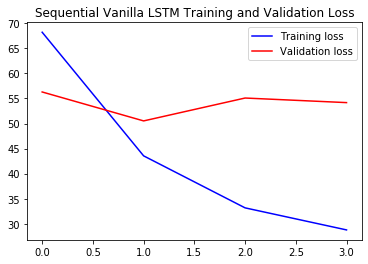


Fold #2


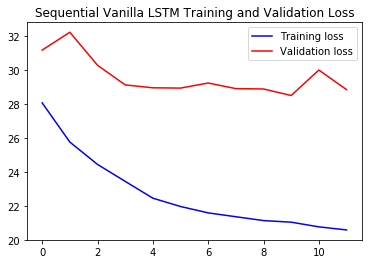


Fold #3


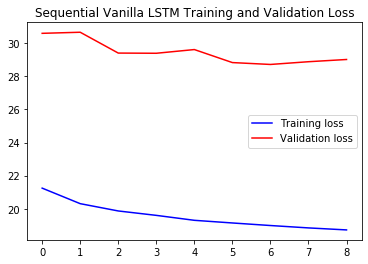


Fold #4


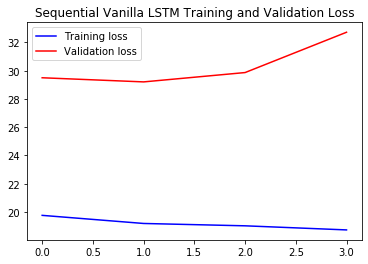

[[[ 1.80969199e+00  7.54251293e+02  3.26295435e+00 -1.50882081e+00]
  [ 1.52887249e+00  2.91496650e+05  2.53293738e+00 -3.62377850e+01]
  [ 1.35546313e+00  2.31974788e+08  2.23279850e+00 -1.08939651e+03]]

 [[ 9.15692296e-01  1.30242920e+05  1.44241515e+00 -4.37274872e+01]
  [ 9.26196814e-01  5.27449102e+07  1.17708669e+00 -1.05054169e+03]
  [ 8.52930983e-01  4.03464179e+10  1.00470642e+00 -3.15604160e+04]]]
[[[ 1.75881923e+00  6.96441116e+02  3.22024761e+00 -1.43105265e+00]
  [ 1.44159008e+00  2.63343348e+05  2.49207116e+00 -3.42791151e+01]
  [ 1.26493978e+00  1.96794760e+08  2.22879710e+00 -1.01136832e+03]]

 [[ 9.13951791e-01  1.20458716e+05  1.41039356e+00 -4.14459417e+01]
  [ 9.14237767e-01  4.79983783e+07  1.13804001e+00 -9.93764621e+02]
  [ 8.54000675e-01  3.40361948e+10  9.87597171e-01 -2.92369719e+04]]]


In [19]:
lstm_model = None

metrics = np.zeros((2, 2, 3, 4))

for i in range(1):
    lstm_model = Sequential()
    lstm_model.add(LSTM(4, input_shape=(timesteps, n_features), return_sequences=True))
    lstm_model.add(LSTM(4, return_sequences=True))
    lstm_model.add(TimeDistributed(Dense(16, activation='relu')))
    lstm_model.add(TimeDistributed(Dense(1)))
    
    print("-----Experiment #" + str(i + 1) + "-----")
    metrics = metrics + utils.walk_forward_cv(
        lstm_model, 
        train_folds, 
        val_folds, 
        test_folds, 
        callbacks=callbacks,
        verbose=verbose, 
        model_name="Sequential Vanilla LSTM",
        val_agg_df=val_agg_ref,
        test_agg_df=test_agg_ref
    ) / N

print(metrics[0] * N)
print(metrics[1] * N)
    
# print("\nOverall Validation:")
# utils.print_metrics(*metrics[0])
# print("\nOverall Test:")
# utils.print_metrics(*metrics[1])

# [[[ 3.30487633e+01  7.41074758e+03  4.91963376e+01 -1.65694177e+01]
#   [ 2.46863779e+01  1.99842694e+06  3.29291207e+01 -3.98302506e+02]
#   [ 2.05480980e+01  1.23147963e+09  2.61883659e+01 -1.19099284e+04]]

#  [[ 1.39152798e+01  1.20841454e+06  2.10602179e+01 -4.80126149e+02]
#   [ 1.14336762e+01  4.11468366e+08  1.58471868e+01 -1.15471003e+04]
#   [ 9.83055881e+00  2.49937720e+11  1.21563468e+01 -3.45002723e+05]]]
# [[[ 4.02658584e+01  6.21869045e+03  4.58128754e+01 -1.28516679e+01]
#   [ 3.12766842e+01  1.60925836e+06  3.01592396e+01 -3.08032131e+02]
#   [ 2.70873877e+01  1.00510917e+09  2.44213697e+01 -9.18515166e+03]]

#  [[ 1.16919006e+01  8.85880320e+05  1.83767440e+01 -3.72297511e+02]
#   [ 9.06653208e+00  2.92221735e+08  1.34080050e+01 -8.93037194e+03]
#   [ 7.31203459e+00  1.71301673e+11  1.01976685e+01 -2.65953972e+05]]]